# ４章　word2vecの高速化

前章で用いたCBOWモデルの計算は相対的に見てカウントベースよりも速いものでしたが、語彙数がある程度増えると同様に時間がかかってしまいます。  
    
そこで今回は**word2vecの高速化**をメインテーマとして改良を行っていきたいと思います。  
  
改良点は以下の２つです。

- 入力層のone-hot表現と重みW_inの積の計算
- 中間層と重みW_outの積およびsoftmaxレイヤの計算

In [1]:
#必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## word2vecの改良①

### **Embeddingレイヤ**

前章のword2vecの実装では入力をone-hot表現に変換し、MatMulレイヤで行列計算を行いました。  
  
しかし、その計算は本当に必要でしょうか？  
  
ここで行っているのは単に重み行列から特定の行を抜き出すだけのことです。  
  
よく考えるとone-hot表現も重みとの積も必要なさそうですね。  
  
それでは新たに「重み行列から対象の行を抜き出す」レイヤを作りましょう！

In [2]:
W=np.arange(21).reshape(7,3)
print(W)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]


行列から特定の行を抜き出すのは簡単で、W[2]のように指定するだけです。

In [3]:
print(W[2])
print(W[5])

[6 7 8]
[15 16 17]


また、複数の行をまとめて取り出すこともできます。

In [4]:
#Wから複数の行を抜き出す
idx = np.array([1,0,3,0])
print(W[idx])

[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]]


それではEmbeddingレイヤとして実装していきましょう。  
  
まずは順伝播からです。

In [5]:
#Eembeddingレイヤの実装
class Embedding:
    def __init__(self, W):
        self.params=[W]
        self.grads=[np.zeros_like(W)]
        self.idx=None

    def forward(self, idx):
        W, = self.params
        self.idx=idx
        out=W[idx]
        return out

次は逆伝播です。  
  
順伝播では重みの特定の行を抜き出す操作をしました。そのため逆伝播では出力層側から伝わってきた勾配をそのまま入力層側に流すだけになります。  
  
図で表すと以下のようになります。

![alt text](pict15.png)

In [6]:
#逆伝播
def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    dW[self.idx] = dout #悪い例
    return None

実はこの実装には問題があります。  
  
それはidxが重複した際に上書きされてしまい、片方の情報が落ちてしまう可能性があることです。  
  
そのため今回は代入から加算に変更します。

In [7]:
#逆伝播の修正
def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    np.add.at(dW, self.idx, dout)
    
    return None

In [8]:
#Embeddingレイヤ
class Embedding:
    def __init__(self, W):
        self.params=[W]
        self.grads=[np.zeros_like(W)]
        self.idx=None

    def forward(self, idx):
        W, = self.params
        self.idx=idx
        out=W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

これで１つ目の問題が解決できました

## word2vecの改良②

それではword2vec改良後編に入ります。  
  
入力層側の改良のときに話した通り巨大な行列の積の計算には多大な時間とメモリを要します。  
  
前章のword2vecを見てみると中間層側も同様の行列の積で実装されています。  
  
ここも要改善ポイントですね。
  
また、語彙数が100万のときのSoftmaxの計算も改めて見てみましょう

$$
\text{softmax}(s_{k}) = \frac{\text{exp}(s_{k})}{\sum_{i=1}^{1000000}\text{exp}(s_{i})}
$$

分母の計算は語彙数が増えれば増えるほど計算回数が増えていき、大きいコーパスを扱うには少々重い計算になってしまいます。

### **多値分類から二値分類へ**

これからNegative Samplingの説明に入っていきますが、はじめにキーとなる二値分類への近似を考えていきます。  
  
多値分類を二値分類に変えるというのは  
  
いままで「ターゲットはなにか？」という質問だったのを「ターゲットは〇〇ですか？」という質問に変えることを意味します。  
  
この変換で変わるのは**出力層のニューロンの数**です。  
  
例えば「ターゲットはsayですか？」という質問であればsayに対応する列だけを抽出して計算すればいいのです。  

![alt text](pict16.png)

二値分類の場合、活性化関数と損失関数はシグモイド関数と交差エントロピー誤差を用います。
  
定義は以下に記述したとおりです。
  
シグモイド関数
$$
y = σ(x) = \frac{1}{1 + \text{exp}(-x)}
$$
  
  
交差エントロピー誤差  
$$
L = -(t\text{log}(y)+(1-t)\text{log}(1-y))
$$
  
  
シグモイド関数は値域が(0,1)の非線形関数で、それぞれの要素の「確率」と見ることができます。
  
交差エントロピー誤差は正解のラベルと予測の間の不一致を測定します。  
  
tは正解ラベル、yはシグモイド関数で計算された確率です。  
  
今回は後ほどこれらをまとめてSigmoid with Lossレイヤとして実装します。

In [43]:
#SigmoidWithLossレイヤの実装(復習)
from common.functions import cross_entropy_error

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

### **Negative Sampling**

ニューラルネットワークで学習するとき正解と同じくらい不正解の例も学習しなければいけません。  
  
正解の学習ではシグモイド関数の出力が1に近づくようにパラメータを更新します。  
  
不正解の例では逆で、出力が0に近づくように学習してくれることが望ましいです。

![alt text](pict17.png)

学習の仕方は分かりましたがこれを全部の負例に対してやるのでしょうか？  
  
答えは否です。そんなことをしてしまっては本章の目的が達成できません。  
  
そこで今回は負例をいくつかピックアップしてそれらを使って学習します。  
  
この手法を**Negative Sampling**といいます。  
  
まとめると正例と負例についてそれぞれで損失を求め、その総和を最終的な損失として学習をします。

![alt text](pict18.png)

さて、説明すべきことは負例のサンプリング方法だけになりました。   
  
採用する負例の個数はあとで設定するとしても100万個ある単語の中からどうやってサンプリングするかはとても重要です。  
  
完全ランダムにサンプリングするのも一つの手ですがもっといい方法があります。  
  
それは**コーパス内の単語の使用頻度に基づいてサンプリングする方法**です。  
  
この使用頻度に応じたサンプリングにはnp.random.choice()関数を使います。

In [12]:
#random.choiceの使い方
import numpy as np
np.random.choice(10)

9

In [13]:
#wordsの中からランダムに一つ選ぶ
words=['you','say','goodbye','I','hello','.']
np.random.choice(words)

'say'

In [14]:
#5つだけランダムに選ぶ（重複あり）
np.random.choice(words, size=5)

array(['hello', 'goodbye', 'hello', '.', '.'], dtype='<U7')

In [15]:
#5つだけランダムに選ぶ（重複なし）
np.random.choice(words, size=5, replace=False)

array(['.', 'you', 'hello', 'goodbye', 'say'], dtype='<U7')

In [17]:
#確率分布に従ってサンプリング
p=[0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

random.choice()の引数は以下の３つです  
size：サンプリングの回数指定  
replace：重複の有無（デフォルトはTrue）  
p：確率分布を指定  
  
さてword2vecでは与える確率分布にも一手間加えています。  
  
それは確率分布の小数乗を行うことです。  
  
この操作の意図は出現確率の低い単語の確率を少しだけ上げ、それらの単語を見捨てないようにするためです。  

In [25]:
p=[0.7, 0.29, 0.01]
new_p=np.power(p, 0.75) #累乗する関数np.power
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


これらの操作をUnigramSamplerクラスとしてまとめます。

In [44]:
#UnigramSamplerの実装
import collections
from common import config
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


In [46]:
#UnigramSamplerのサンプリング
import numpy as np
import collections

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[4 2]
 [1 4]
 [3 2]]


それでは順番に実装していきましょう！

### **後半の実装**

二値分類の全体像は以下の様になります  

![alt text](pict19.png)

・EmbeddingDotレイヤの実装  
・Negative Sampling Lossレイヤの実装  
・改良版CBOWの実装  
  
順に実装していきましょう！

・EmbeddingDot  
  
二値分類に変わった中間層からの計算は
  
W_outから対応するベクトルを抽出して中間層から受け取ったhとの内積計算と記述できます。  
   
今回はこれをEmbeddingDotレイヤとしてまとめて実装します。

In [29]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W) #Embeddingレイヤ
        self.params = self.embed.params #パラメータ
        self.grads = self.embed.grads #勾配 
        self.cache = None #順伝播の際の中間データ

    def forward(self, h, idx):
        target_W = self.embed.forward(idx) #下で解説
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [30]:
#forwardの処理解説
W = np.arange(21).reshape(7,3)
idx = np.array([0,3,1])
h = np.array([[0,1,2],[3,4,5],[6,7,8]]) #中間層のニューロン
embed = Embedding(W)
target_W = embed.forward(idx)
out = np.sum(target_W * h, axis=1)
#W、idx,target_W,h,target_W * h, outを表にして出力
print("W")
print(W)
print("idx")
print(idx)
print("target_W")
print(target_W)
print("h")
print(h)
print("target_W * h")
print(target_W * h)
print("out")
print(out)


W
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
idx
[0 3 1]
target_W
[[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]]
h
[[0 1 2]
 [3 4 5]
 [6 7 8]]
target_W * h
[[ 0  1  4]
 [27 40 55]
 [18 28 40]]
out
[  5 122  86]


・NegativeSamplingLossの実装  
  


In [31]:
#NegativeSamplingLossの実装
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size #負例のサンプリング数
        self.sampler = UnigramSampler(corpus, power, sample_size) #UnigramSamplerの保持
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] #SigmoidWithLossレイヤの保持
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)] #EmbeddingDotレイヤの保持

        #lossレイヤとembed_dotレイヤは負例の数＋正例(sample_size+1)個分用意する

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target): #引数は中間層のニューロンhとターゲットの単語ID
        batch_size = target.shape[0] #バッチサイズ
        negative_sample = self.sampler.get_negative_sample(target) #負例のサンプリング

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32) #正例の正解ラベルは1
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32) #負例の正解ラベルは0
        for i in range(self.sample_size): #負例の数だけループ
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label) #負例の損失を加算
        
        #lossには正例の損失と負例の損失が合算されている

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

・改良版CBOWモデル  
それでは準備が整ったので改良版CBOWモデルを実装していきましょう

In [32]:
#改良版CBOWモデルの実装
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding
#from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

それではこのCBOWモデルで学習していきましょう

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 2[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 2[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 3[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 4[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 5[s] | loss 3.61
| epoch 1 |  iter 161 / 9295 | time 5[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 6[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 7[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 7[s] | loss 3.15
| epoch 1 |  iter 241 / 9295 | time 8[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 9[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 9[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 10[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 11[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 12[s] | loss 2.83
| epoch 1 |  iter 361 / 9295 | time 12[s] | loss 

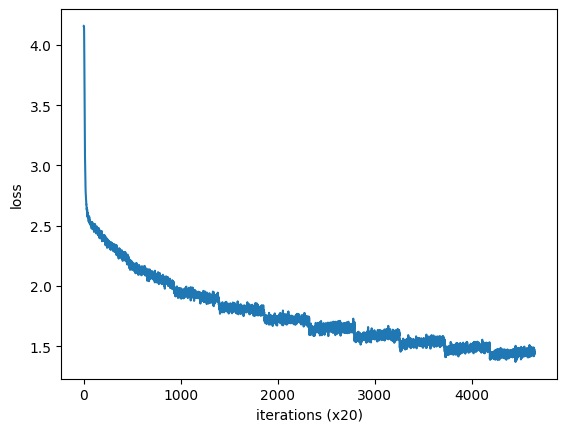

In [38]:
#GPUを使わないと1時間かかるので注意
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は、下記のコメントアウトを消去（要cupy）
# ===============================================
# config.GPU = True
# ===============================================
from common.np import *
import pickle
from common.functions import cross_entropy_error
from common.trainer import Trainer
from common.optimizer import Adam
#from common.cbow import CBOW
#from common.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [39]:
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle

pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# most similar task
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.71923828125
 i: 0.7109375
 your: 0.61865234375
 they: 0.599609375
 anything: 0.58935546875

[query] year
 month: 0.83984375
 summer: 0.75634765625
 week: 0.75244140625
 spring: 0.7490234375
 decade: 0.70556640625

[query] car
 truck: 0.63671875
 window: 0.61083984375
 auto: 0.6025390625
 cars: 0.59716796875
 luxury: 0.55517578125

[query] toyota
 mazda: 0.64404296875
 nissan: 0.62255859375
 seita: 0.615234375
 tires: 0.60986328125
 honda: 0.60693359375


In [42]:
analogy('king', 'man','queen', word_to_id, id_to_word, word_vecs, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs, top=5)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs, top=5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs, top=5)


[analogy] king:man = queen:?
 a.m: 6.06640625
 woman: 5.23046875
 mother: 4.9453125
 daffynition: 4.86328125
 gene: 4.53125

[analogy] take:took = go:?
 eurodollars: 4.75390625
 came: 4.30859375
 're: 4.15234375
 went: 4.1328125
 goes: 4.03515625

[analogy] car:cars = child:?
 a.m: 6.3828125
 children: 5.73828125
 rape: 5.41015625
 adults: 5.2109375
 women: 4.94140625

[analogy] good:better = bad:?
 rather: 5.171875
 more: 5.1484375
 less: 4.8046875
 worse: 3.939453125
 greater: 3.712890625
